# Preamble

In [1]:
# Imports
## General
import numpy as np
import pickle as pkl
import json
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import time
import datetime
import sys

## In order to run calculations on AWS GPU, need to explicitly specify CUDA lib directory in the environment variables
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/sagemaker-user/.conda/envs/mlds_gpu"

## Data manipulation and preprocessing
import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler, FunctionTransformer,LabelEncoder, MinMaxScaler,OrdinalEncoder
#import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, MissingIndicator
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy import sparse
from tensorflow.keras.layers import StringLookup, Normalization

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

## Modelling
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Concatenate, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import tensorflow as tf

## Import DeepCTR code
## This is done by cloning the github repository instead of installing with pip. This is because of an incompatibility issue
## with TF 2.14 that I had to manually fix in the DeepCTR code
deepctr_path = '/home/sagemaker-user/drl-ad-personalization/DeepCTR'
if deepctr_path not in sys.path:
    sys.path.append(deepctr_path)

from deepctr.models.fnn import FNN
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.models.pnn import PNN
from deepctr.models.wdl import WDL
from deepctr.models.deepfm import DeepFM
from deepctr.models.autoint import AutoInt
from deepctr.models.fgcnn import FGCNN
from deepctr.models.nfm import NFM
from deepctr.models.dcn import DCN
from deepctr.models.ccpm import CCPM

2024-08-28 05:32:37.903787: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 05:32:38.258091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 05:32:38.258121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 05:32:38.258131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 05:32:38.441604: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpu_devices = tf.config.list_physical_devices('GPU')
gpu_devices

2024-08-28 05:32:45.741284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 05:32:46.061776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 05:32:46.063569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Introduction


The global digital advertising market is worth approximately \\$602 billion today. Due to the increasing rate of of online participation since the 
COVID-19 pandemic, this number has been rapidly increasing and is expected to reach \\$871 billion by the end of 2027 \citep{RefWorks:emarketer2023digital}.
Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that 
advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content 
shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) 
prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of 
Machine Learning research over the past through years.

Initially, shallow prediction methods such as Logistic Regression, Factorization Machines (Rendel, 2020) and Field-Aware Factorization 
Machines \citep{RefWorks:juan2016field-aware} have been used for CTR prediction. However, these methods have often been shown to be unable to capture the 
higher order feature interactions in the sparse multi-value categorical Ad Marketplace datasets \citep{RefWorks:zhang2021deep}. Since then, Deep Learning methods have been 
shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep 
Learning architechtures for click-through rate prediction.

A number of Deep Learning models have been proposed for CTR prediction, some of which will be explored in this report. Each of these models
outperform their shallow counterparts in terms of predictive ability. In a static environment, these models are able to serve the CTR prediction
function of Ad personalization, but in a dynamic environment, the model must be able to adapt to the changing user preferences. This is where
Reinforcement Learning comes in. Reinforcement Learning is a type of Machine Learning that is used to make a sequence of decisions in an environment
in order to maximize some notion of cumulative reward. In the context of Ad personalization, the environment is composed of the user, the Ad platform
and the advertisments, whereas the reward is the users' engagement with the advertisments and with the Ad platform.


As outlined in the Feasibility secition of my Milestone 3 submission, I have segmented the work over the next few weeks according to the following timeline

![](figures/timeline.png)

Below I proceed by structuring my response according to the following sections
- General Background to Deep CTR and Deep Renforcement Learning
- Data exploration, preprocessing and environment setup
- Model Introduction, Replication and Experimentation

Please note that this notebook illustrates my current work in progress, and certain sections are far from finished. I have also concurrently begun sections of my final write up using the LaTeX template provided. This is available along with the rest of my code in the following Github repository: https://github.com/martinbatek/drl-ad-personalization

# Background

## Deep CTR Prediction

In their respective surveys on the use of Deep Learning methods for CTR prediction, (Gu, 2021) and (Zhang et al., 2021) outline the 
problem of CTR prediction as one that essentially boils down to a binary (click/no-click) classification problem utilizing user/ad-view event level 
online session records. The goal of CTR prediction is to predict the probability of a user clicking on an advertisment given the information available
about the user, advertisment and the context in which the advertisement is shown. Suppose that $\mathbf{x} \in \mathbb{R}^n$
is a vector of features that describes the user, ad and platform for a given instance, and
$y \in \{0, 1\}$ is the binary label indicating whether the user clicked on the ad or not. The goal of CTR prediction is to learn a function
$f: \mathbb{R}^n \rightarrow (0,1)$ such that:

$$
f(\mathbf{x}) = \mathbb{P}(y = 1 | \mathbf{x}) = \mathbb{P}(\text{click}| \mathbf{x})
$$

In other words, for a given set of features $\mathbf{x}$, the model should output the probability that the user will click on the ad.
A defining characteristic for this type of data is that many of the features are multi-value categories with a high degree of of cardinality \citep{RefWorks:he2017neural}. 
This in turn means that the ad marketplace datasets used for CTR predictions can be extremely sparse, which increases the difficulty of the classification problem at 
hand \citep{RefWorks:gu2021ad}.

A key requirement for CTR modelling is therefore working out which of the many sparse features and feature 
interactions (combinations of two or more features) are significant for determining the correct prediction 
(Gu, 2021). Factorization Machines (Rendle, 2010) and Field-aware Factorization Machines (Juan et al., 2016) 
were popularized shallow modelling methods that explicitly account for first order interactions between features. 
However, these techniques do not capture higher order interactions (combinations of three or more features) and 
have thus been known to perform poorly in scenarios with highly sparse data (Zhang et al., 2021). Since 2015 the 
research cummunity has been increasingly turning to Deep Learning techniques to enhance prior CTR prediction 
techniques (such as in the case of DeepFM (Guo et al., 2017)), as well as to develop novel approaches. Neural based 
network models excel at simulataneoulsy extracting high-order and low-order feature interations virtue to the use 
of pooling layers, multiple hidden layers and activation units (Gu, 2021). Due the aforementioned importance of 
feature interation modelling, a number of Feature Interaction Operator layers have been developed to explicitly 
capture the key combinations of features. These layers are then typically incorporated with a supplimentary Deep 
Neural Network in a single or dual tower architecture, as shown in the Figure below:

![DNN_Architecture](figures/single_dual_dnn.png)


Feature Interaction Operators can be categorized as either Product Operators, Convolutional Operators or Attention Operators. Product Operators such as the Product-based Neural Network (PNN) (Qu et al., 2016), Neural Factorization Machines (NFM) (He & Chua, 2017), Deep and Cross Network (Wang et al., 2017) and Gated Deep Cross Network (GDCN) (Wang, F. et al., 2023) introduce a product layer between the categorical feature embedding layer and the rest of the neural network in order to explicitly model the important feature interactions. Convolutional Operators such as the Convolutional Click Prediction Model (CCPM) (Liu et al., 2015) utilized convolution, pooling and non-linear activation in order to calculate arbitrary-order interactions. Finally, Attention Operators such as Attentional Factorization Machines (AFM) (Xiao et al., 2017), AutoInt (Song et al., 2019) and Interpretable CTR prediction model with Hierarchical Attention (InterHAt) (Li et al., 2020) utilize the attention mechanism to enable different feature interactions to contribute differently to the prediction.

## Deep Reinforcement Learning

In their survey, (Wang, X. et al., 2024) describe how deep reinforcement learning combines the aforementioned feature extraction capabilities of DNN’s with the decision-making capability of reinforcement learning, which aims to learn an optimal state-action policy which maximizes the expected reward gained in a given environment. In the context of recommendation systems, a significant amount of research has been dedicated to formulating the recommendation problem as a Contextual Multi-Armed Bandit (MAB) problem setting, where the context consists of user, site and item features (Bouneffouf, Bouzeghoub & Gancarski, 2012; Li, L. et al., 2010; Zeng et al., 2016). However, a shortcoming for the MAB approach is that it does not explicitly model the future expected reward for the policy, which may be detrimental in the longer term (Zheng et al., 2018). Markov Decision Process (MDP) models solve for this issue by modelling the state-action progression as a Markov Process, allowing for the stochastic valuation of the future potential rewards for a given recommendation policy (Lu & Yang, 2016; Mahmood & Ricci, 2007). DRN (Zheng et al., 2018) is a MDP framework that leverages a Deep Neural Network to approximate the expected total user response for each recommendation at each state. The two major advantages of DRN are firstly that it is composed on the basis of a continuous state and action representation, meaning that it can be scaled to large and sparse datasets, and secondly that the proposed reward function consists of both the immediate reward (user click) as well as the future expected reward (long term user engagement), thereby allowing for better recommendations over a user’s lifetime.

# Data Exploration, Caching, Preprocessing pipeline

## Data Exploration

TBD - Include data Exploration sections from Milestone 2

## Load benchmark datasets as tf.datasets

### KDD12

In [3]:
# Load the kdd12_train dataset
kdd12_train = tf.data.experimental.make_csv_dataset(
    "data/kdd12/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    #label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

2024-08-28 05:32:46.096555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 05:32:46.098245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 05:32:46.099879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# Load the kdd12_train dataset
kdd12_val = tf.data.experimental.make_csv_dataset(
    "data/kdd12/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    #label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [5]:
# Define function to derive ctr and split this as the target
@tf.function
def kdd12_target(element,t=0.5):
    features = element.copy()
    click = features.pop(key='click')
    impression = features.pop(key="impression")
    ctr_label = tf.where(tf.math.greater_equal(tf.math.divide(click,impression),t),1,0)
    return features, ctr_label

In [6]:
# Apply to datasets
kdd12_train = kdd12_train.map(kdd12_target)
kdd12_val = kdd12_val.map(kdd12_target)

In [7]:
kdd12_train.element_spec

(OrderedDict([('displayurl',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('adid', TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('advertiserid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('depth', TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
              ('position',
               TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
              ('keywordid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('titleid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('descriptionid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('queryid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None)),
              ('userid',
               TensorSpec(shape=(None,), dtype=tf.string, name=None))]),
 TensorSpec(shape=(None,), dtype=tf.int32, name=N

In [8]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in kdd12_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in kdd12_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.248948
Time taken 256 records val: 0:00:00.150076


### Avazu

In [9]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]
avazu_train = tf.data.experimental.make_csv_dataset(
    "data/avazu/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [10]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]

# Load the Avazu train dataset
avazu_val = tf.data.experimental.make_csv_dataset(
    "data/avazu/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [11]:
# Drop ID variable
def drop_id(features, label):
    out_features = features.copy()
    del out_features['id']
    return out_features, label

In [12]:
avazu_train = avazu_train.map(drop_id)
avazu_val = avazu_val.map(drop_id)

In [13]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in avazu_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in avazu_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.202952
Time taken 256 records val: 0:00:00.194780


### Criteo

In [14]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_train = tf.data.experimental.make_csv_dataset(
    "data/criteo/train_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [15]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_val = tf.data.experimental.make_csv_dataset(
    "data/criteo/test_split/*",
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

In [16]:
# Print time taken to iterate through 256 records 
start_time = datetime.datetime.now()
i = 0
for element in criteo_train.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records train:",end_time-start_time)

start_time = datetime.datetime.now()
i = 0
for element in criteo_val.take(256):
    i +=1
end_time = datetime.datetime.now()
print(f"Time taken {i} records val:",end_time-start_time)

Time taken 256 records train: 0:00:00.310553
Time taken 256 records val: 0:00:00.553735


## Preprocessing

Below I construct the preprocessing pipeline for the tensorflow datasets on the basis of the exploration functions above. I proceed by:

- Enconding the sparse catecorically features using the Ordinal Encoders specified above.
- Standardizing the numerical features unsing the Scalers and Transformer specified above.
- Generating the feature columns, as specified in the [DeepCTR Quickstart Guide](https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html#step-3-generate-feature-columns)

In [17]:
## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'C1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'C14',
    'C15',
    'C16',
    'C17',
    'C18',
    'C19',
    'C20',
    'C21'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]
criteo_categorical_columns = [f'cat_{i}' for i in np.arange(1,27)]

### Categorical Variable Encoding

In [18]:
# Import categorical feature mappings and define stringloohup objects for each dataset
kdd12_stringlookups = {}
kdd12_vocab_lengths = {}
for field in kdd12_categorical_columns:
    df = pd.read_csv(f'./data/kdd12/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    kdd12_stringlookups.update({field:lookup})
    kdd12_vocab_lengths.update({field:len(vocab)+1})

avazu_stringlookups = {}
avazu_vocab_lengths = {}
for field in avazu_categorical_columns:
    df = pd.read_csv(f'./data/avazu/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    avazu_stringlookups.update({field:lookup})
    avazu_vocab_lengths.update({field:len(vocab)+1})

criteo_stringlookups = {}
criteo_vocab_lengths = {}
for field in criteo_categorical_columns:
    df = pd.read_csv(f'./data/criteo/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    criteo_stringlookups.update({field:lookup})
    criteo_vocab_lengths.update({field:len(vocab)+1})

In [19]:
# Define categorical encoding function
@tf.function
def kdd12_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in kdd12_categorical_columns:
        lookup = kdd12_stringlookups[f]
        out_features[f.lower()] = lookup(features[f.lower()])
    return out_features, label

@tf.function
def avazu_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in avazu_categorical_columns:
        lookup = avazu_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

@tf.function
def criteo_categorical_encoding(features,label):
    # Create copy of features
    out_features = features.copy()
    # Iteratively map the categorical feature columns using the corresponding Lookup layer
    for f in criteo_categorical_columns:
        lookup = criteo_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

In [20]:
# Apply mapping over each dataset

kdd12_train_encoded = kdd12_train.map(kdd12_categorical_encoding)
avazu_train_encoded = avazu_train.map(avazu_categorical_encoding)
criteo_train_encoded = criteo_train.map(criteo_categorical_encoding)

kdd12_val_encoded = kdd12_val.map(kdd12_categorical_encoding)
avazu_val_encoded = avazu_val.map(avazu_categorical_encoding)
criteo_val_encoded = criteo_val.map(criteo_categorical_encoding)

In [21]:
# Print time taken to iterate through 256 records
stage = "encoded"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train encoded: 0:00:00.144332
Time taken 256 records kdd12 val encoded: 0:00:00.141377
Time taken 256 records avazu train encoded: 0:00:00.140282
Time taken 256 records avazu val encoded: 0:00:00.139310
Time taken 256 records criteo train encoded: 0:00:00.138621
Time taken 256 records criteo val encoded: 0:00:00.137341


### Numerical Variable Scaling

In [22]:
# Define numerical feature columns
kdd12_numerical_columns = [
    'Depth',
    'Position'
]

avazu_numerical_columns = [
    'hour'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]

In [23]:
# Extract scaler dicts for all datasets
dist_stats = pd.read_csv('./data/kdd12/means_variances.csv')
kdd12_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    kdd12_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/avazu/means_variances.csv')
avazu_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    avazu_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/criteo/means_variances.csv')
criteo_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    criteo_scalers.update({field:scaler})

In [24]:
# Define scaler functions for all datasets

@tf.function
def kdd12_numerical_scaling(features,label):
    out_features = features.copy()
    for f in kdd12_numerical_columns:
        scaler = kdd12_scalers[f]
        out_features[f.lower()] = scaler(features[f.lower()])
    return out_features, label

@tf.function
def avazu_numerical_scaling(features,label):
    out_features = features.copy()
    for f in avazu_numerical_columns:
        scaler = avazu_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

@tf.function
def criteo_numerical_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        scaler = criteo_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

In [25]:
# Apply the numerical scaling to all datasets
kdd12_train_scaled = kdd12_train_encoded.map(kdd12_numerical_scaling)
avazu_train_scaled = avazu_train_encoded.map(avazu_numerical_scaling)
criteo_train_scaled = criteo_train_encoded.map(criteo_numerical_scaling)

kdd12_val_scaled = kdd12_val_encoded.map(kdd12_numerical_scaling)
avazu_val_scaled = avazu_val_encoded.map(avazu_numerical_scaling)
criteo_val_scaled = criteo_val_encoded.map(criteo_numerical_scaling)

In [26]:
# Print time taken to iterate through 256 records
stage = "scaled"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train scaled: 0:00:00.140637
Time taken 256 records kdd12 val scaled: 0:00:00.142182
Time taken 256 records avazu train scaled: 0:00:00.140426
Time taken 256 records avazu val scaled: 0:00:00.140212
Time taken 256 records criteo train scaled: 0:00:00.141544
Time taken 256 records criteo val scaled: 0:00:00.138488


In [27]:
# Print the element specs
print('KDD12:')
print(kdd12_train_scaled.element_spec)
print()
print('Avazu:')
print(avazu_train_scaled.element_spec)
print()
print('Criteo:')
print(criteo_train_scaled.element_spec)

KDD12:
(OrderedDict([('displayurl', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('adid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('advertiserid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('depth', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('position', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('keywordid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('titleid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('descriptionid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('queryid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('userid', TensorSpec(shape=(None,), dtype=tf.int64, name=None))]), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Avazu:
(OrderedDict([('hour', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('C1', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('banner_pos', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('site_id', Tensor

In [28]:
# Apply log transformation to criteo datase

@tf.function
def criteo_log_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        x = features[f]
        out_features[f] = tf.where(x>2,tf.math.square(tf.math.log(x)),x)
    return out_features, label

In [29]:
criteo_train_scaled = criteo_train_scaled.map(criteo_log_scaling)
criteo_val_scaled = criteo_val_scaled.map(criteo_log_scaling)

In [30]:
# Print time taken to iterate through 256 records
stage = "scaled"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(256):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} records {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 256 records kdd12 train scaled: 0:00:00.142907
Time taken 256 records kdd12 val scaled: 0:00:00.139031
Time taken 256 records avazu train scaled: 0:00:00.140738
Time taken 256 records avazu val scaled: 0:00:00.138266
Time taken 256 records criteo train scaled: 0:00:00.139773
Time taken 256 records criteo val scaled: 0:00:00.136885


In [31]:
# Define model inputs
kdd12_train_model_input = kdd12_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)
avazu_train_model_input = avazu_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)
criteo_train_model_input = criteo_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)

kdd12_val_model_input = kdd12_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)
avazu_val_model_input = avazu_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)
criteo_val_model_input = criteo_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)

In [32]:
# Print time taken to iterate through 1 batch
stage = "model_input"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(1):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} batch {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 1 batch kdd12 train model_input: 0:00:00.053922
Time taken 1 batch kdd12 val model_input: 0:00:00.055509
Time taken 1 batch avazu train model_input: 0:00:00.053759
Time taken 1 batch avazu val model_input: 0:00:00.054395
Time taken 1 batch criteo train model_input: 0:00:00.054389
Time taken 1 batch criteo val model_input: 0:00:00.055669


In [33]:
# One-Hot encode the categorical columns
@tf.function
def one_hot_categorical(features, labels, categorical_columns):
    features_out = features.copy()
    for field in categorical_columns:
        features_out[field] = tf.squeeze(tf.one_hot(features[field],depth=50,dtype=tf.float32),axis=-2)
    return features_out, labels

In [34]:
# One-hot encode the datasets
kdd12_categorical_lower = [x.lower() for x in kdd12_categorical_columns]

kdd12_train_ohe = kdd12_train_model_input.map(lambda x, y: one_hot_categorical(x,y,kdd12_categorical_lower))
kdd12_val_ohe = kdd12_val_model_input.map(lambda x, y: one_hot_categorical(x,y,kdd12_categorical_lower))
avazu_train_ohe = avazu_train_model_input.map(lambda x, y: one_hot_categorical(x,y,avazu_categorical_columns))
avazu_val_ohe = avazu_val_model_input.map(lambda x, y: one_hot_categorical(x,y,avazu_categorical_columns))
criteo_train_ohe = criteo_train_model_input.map(lambda x, y: one_hot_categorical(x,y,criteo_categorical_columns))
criteo_val_ohe = criteo_val_model_input.map(lambda x, y: one_hot_categorical(x,y,criteo_categorical_columns))

In [35]:
# Define function to concatinate all features together
@tf.function
def combine(features, labels):
    columns = list(features.keys())
    out_cols = []
    for field in columns:
        out_cols.append(features[field])
    features_out = tf.concat(out_cols,axis=-1)
    return features_out, labels

In [36]:
kdd12_train_ohe = kdd12_train_ohe.map(combine)
kdd12_val_ohe = kdd12_val_ohe.map(combine)
avazu_train_ohe = avazu_train_ohe.map(combine)
avazu_val_ohe = avazu_val_ohe.map(combine)
criteo_train_ohe = criteo_train_ohe.map(combine)
criteo_val_ohe = criteo_val_ohe.map(combine)

In [37]:
# Print time taken to iterate through 1 batch
stage = "ohe"
for dataset in ["kdd12","avazu","criteo"]:
    for data_split in ["train","val"]:
        data = globals()[f"{dataset}_{data_split}_{stage}"]
        
        start_time = datetime.datetime.now()
        i = 0
        for element in kdd12_train.take(1):
            i +=1
        end_time = datetime.datetime.now()
        print(f"Time taken {i} batch {dataset} {data_split} {stage}:",end_time-start_time)

Time taken 1 batch kdd12 train ohe: 0:00:00.055041
Time taken 1 batch kdd12 val ohe: 0:00:00.054352
Time taken 1 batch avazu train ohe: 0:00:00.053732
Time taken 1 batch avazu val ohe: 0:00:00.053832
Time taken 1 batch criteo train ohe: 0:00:00.054283
Time taken 1 batch criteo val ohe: 0:00:00.053861


In [38]:
# Calculate the input shapes for each of the datasets
kdd12_ohe_shape = (len(kdd12_categorical_columns)*50 + len(kdd12_numerical_columns),)
avazu_ohe_shape = (len(avazu_categorical_columns)*50 + len(avazu_numerical_columns),)
criteo_ohe_shape = (len(criteo_categorical_columns)*50 + len(criteo_numerical_columns),)

### Define Feature columns

In [39]:
## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat.lower(), vocabulary_size=kdd12_vocab_lengths[feat], embedding_dim=4) for feat in kdd12_categorical_columns]\
+ [DenseFeat(feat.lower(),1) for feat in kdd12_numerical_columns]
avazu_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=avazu_vocab_lengths[feat], embedding_dim=4) for feat in avazu_categorical_columns]\
+ [DenseFeat(feat,1) for feat in avazu_numerical_columns]
criteo_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=criteo_vocab_lengths[feat], embedding_dim=4) for feat in criteo_categorical_columns]\
+ [DenseFeat(feat,1) for feat in criteo_numerical_columns]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns

avazu_dnn_feature_columns = avazu_fixlen_feature_columns
avazu_linear_feature_columns = avazu_fixlen_feature_columns

criteo_dnn_feature_columns = criteo_fixlen_feature_columns
criteo_linear_feature_columns = criteo_fixlen_feature_columns

# Model Replication and Experimentation

In [40]:
# Create the model checkpoint directories if they do not exist
for model in ['lr','fm','fnn','pnn','wdl','dfm','autoint','fgcnn','nfm','dcn','ccpm']:
    for dataset in ['kdd12','avazu','criteo']:
        if not os.path.exists(f'./models/{model}/{dataset}'):
            os.makedirs(f'./models/{model}/{dataset}')

In [41]:
# Define the early stopping callback
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Define the precision, recall and auc metrics
precision = tf.keras.metrics.Precision(thresholds=0.5,name='precision')
recall = tf.keras.metrics.Recall(thresholds=0.5,name='recall')
auc = tf.keras.metrics.AUC(name='auc')

# Define the Class weights
kdd12_class_weights = {0: 0.5264044470647687, 1: 9.968102073365232}
#criteo_class_weights = {0: 0.6691021986698248, 1: 1.9783959165908283}
#avazu_class_weights = {0: 0.6022935337766213, 1: 2.943947244465379}

## Shallow Models

In order assess the effectiveness of Deep Learning methods for CTR prediction, it makes sense to attain a model score using more traditional model architectures in order to use these as a comparison. (Zhang et al., 2021) briefly discuss the how CTR applications steadily progressed from Shallow to Deep models. The most basic shallow model for the CTR binary classification task is Logistic Regression (Richardson, Dominowska & Ragno, 2007) which benefits from “high efficiency and ease for fast deployment” (Zhang et al., 2021). However, as it became apparent that identifying key feature interactions is crucial for the CTR prediction task, architectures that explicitly capture these interactions such as the Factorization Machine (Juan et al., 2016; Rendle, 2010) became increasingly popular in the domain.

In order to attain representitive results from beyond the realm of deep learning, below I evaluate two of the most poplarly used shallow models for CTR prediction:

- [Logistic regression](https://www.tensorflow.org/guide/core/logistic_regression_core)
- Factorization machines

### Logistic Regression

In logistic regression, we use the logistic (a.k.a. sigmoid) function as our function $f_\theta$, i.e:
$$
\mathcal{P}\left(\mathrm{Click}\right)=\frac{e^{\beta_0+\sum_{i}{\beta_ix_i}}}{1+e^{\beta_0+\sum_{i}{\beta_ix_i}}}
$$
(James et al., 2021) show that the equation above can be rearranged as follows:
$$
\beta_0+\sum_{i}{\beta_ix_i}=log{\left(\frac{\mathcal{P}\left(\mathrm{Click}\right)}{1-\mathcal{P}\left(\mathrm{Click}\right)}\right)}
$$
Logistic regression therefore effectively amounts to fitting a linear regression function to the log odds of a that there is a click for a given instance, parameterized by $\theta=\left(\beta_0,\beta_1,\ldots,\beta_n\right)$. (Richardson, Dominowska & Ragno, 2007) showed that it is possible to fit a logistic regression model on search advertising data in order to provide accurate click-through rate predictions for each ad, and even demonstrated that the used of this model “improves convergence and performance on the advertising system”. As stated previously, a major benefit of the logistic model over all of the others mentioned here is that since it works on the basis of a simple linear combination of the given features, it is the simplest model to fit and deploy. However, a major shortcoming of this model is the fact that it does not account for feature interactions, and it therefore fails to pick up on discriminating patterns given by the cross-features in the highly sparse categorical ad marketplace data (Zhang et al., 2021).


Below, I replicate the Logistic regression model in Tensorflow by defining a `Sequential` model class with a single `Dense` layer with sigmoid activation. The Dense layer simply implements the linear combination $\beta_0+\sum_{i}{\beta_ix_i}$ from above, before passing the result through the sigmoid function $\sigma(x) = \frac{e^x}{1+e^x}$.

In [43]:
# Define the CSVLogger callbacks
kdd12_lr_csvLogger = CSVLogger('logs/kdd12_lr.csv')
avazu_lr_csvLogger = CSVLogger('logs/avazu_lr.csv')
criteo_lr_csvLogger = CSVLogger('logs/criteo_lr.csv')

In [44]:
# Define the model saving checkpoints
# Define the model saving checkpoints
kdd12_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/kdd12/kdd12_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/avazu/avazu_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_lr_modelCheckpoint = ModelCheckpoint(
    'models/lr/criteo/criteo_lr.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [45]:
# Define a single dense layer sequential model using sigmoid activation function

kdd12_lr_model = Sequential([
    Input(shape=kdd12_ohe_shape),
    Dense(1,activation='sigmoid')
])
avazu_lr_model = Sequential([
    Input(shape=avazu_ohe_shape),
    Dense(1,activation='sigmoid')
])
criteo_lr_model = Sequential([
    Input(shape=criteo_ohe_shape),
    Dense(1,activation='sigmoid')
])

In [46]:
# Compile the models
sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)


kdd12_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
'''
avazu_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
criteo_lr_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
'''

'\navazu_lr_model.compile(\n    optimizer=sgd_optimizer,\n    loss="binary_crossentropy",\n    metrics=[\'binary_crossentropy\',\'binary_accuracy\',precision,recall,auc]\n)\ncriteo_lr_model.compile(\n    optimizer=sgd_optimizer,\n    loss="binary_crossentropy",\n    metrics=[\'binary_crossentropy\',\'binary_accuracy\',precision,recall,auc]\n)\n'

In [47]:
# Fit the models to the datasets

kdd12_lr_model.fit(
    kdd12_train_ohe,
    validation_data=kdd12_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[kdd12_lr_csvLogger, kdd12_lr_modelCheckpoint, earlystopping],
    class_weight=kdd12_class_weights,
)
'''
avazu_lr_model.fit(
    avazu_train_ohe,
    validation_data=avazu_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[avazu_lr_csvLogger, avazu_lr_modelCheckpoint, earlystopping]
)

criteo_lr_model.fit(
    criteo_train_ohe,
    validation_data=criteo_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[criteo_lr_csvLogger, criteo_lr_modelCheckpoint, earlystopping]
)
'''

Epoch 1/15


2024-08-27 18:20:46.012333: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


615/615 [==============================] - 24s 35ms/step - loss: 0.6346 - binary_crossentropy: 0.6941 - binary_accuracy: 0.5166 - precision: 0.0382 - recall: 0.4517 - auc: 0.4756 - val_loss: 0.6847 - val_binary_crossentropy: 0.6847 - val_binary_accuracy: 0.5930 - val_precision: 0.0414 - val_recall: 0.4037 - val_auc: 0.5048
Epoch 2/15
615/615 [==============================] - 22s 36ms/step - loss: 0.6278 - binary_crossentropy: 0.6752 - binary_accuracy: 0.6987 - precision: 0.0465 - recall: 0.3295 - auc: 0.5364 - val_loss: 0.6676 - val_binary_crossentropy: 0.6676 - val_binary_accuracy: 0.7495 - val_precision: 0.0552 - val_recall: 0.3180 - val_auc: 0.5761
Epoch 3/15
615/615 [==============================] - 22s 35ms/step - loss: 0.6226 - binary_crossentropy: 0.6598 - binary_accuracy: 0.7640 - precision: 0.0548 - recall: 0.2963 - auc: 0.5836 - val_loss: 0.6536 - val_binary_crossentropy: 0.6536 - val_binary_accuracy: 0.7635 - val_precision: 0.0609 - val_recall: 0.3317 - val_auc: 0.6066
Epo

'\navazu_lr_model.fit(\n    avazu_train_ohe,\n    validation_data=avazu_val_ohe,\n    batch_size=256,\n    epochs=15,\n    callbacks=[avazu_lr_csvLogger, avazu_lr_modelCheckpoint, earlystopping]\n)\n\ncriteo_lr_model.fit(\n    criteo_train_ohe,\n    validation_data=criteo_val_ohe,\n    batch_size=256,\n    epochs=15,\n    callbacks=[criteo_lr_csvLogger, criteo_lr_modelCheckpoint, earlystopping]\n)\n'

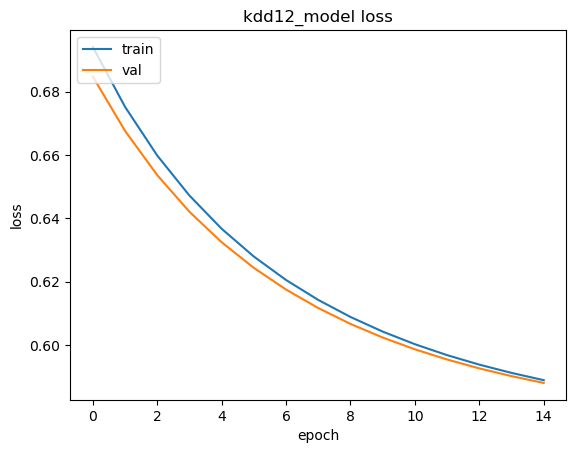

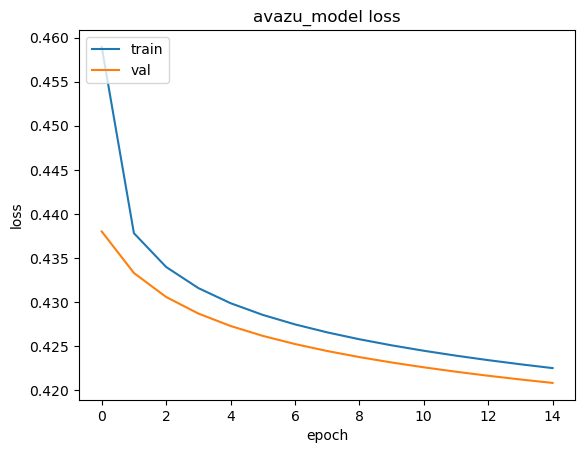

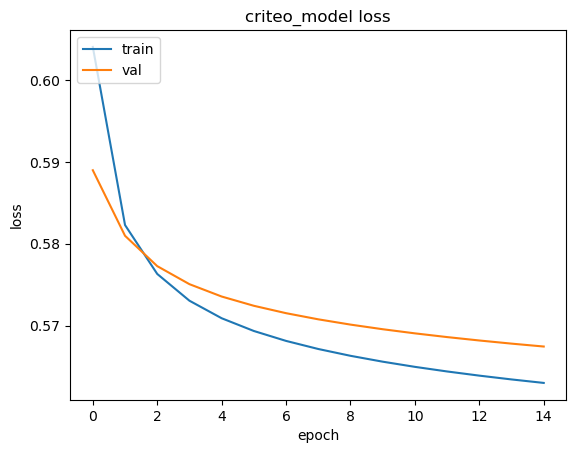

In [48]:
# Plot the training and validation losses for each epoch
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_lr.csv')
avazu_history = pd.read_csv('logs/avazu_lr.csv')
criteo_history = pd.read_csv('logs/criteo_lr.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Factorization Machine

Factorization Machines were first introduced in \citep{RefWorks:rendle2010factorization} as
a model class that ``combines the advantages of Support Vector Machines (SVM) with factorization models''.
The model is able to capture the second order feature interactions in the data, which is a key advantage over
Logistic Regression. The model is defined as follows:

$$
\hat{y}(\mathbf{x}) = w_0 + \sum_{i=1}^{n} w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \mathbf{v}_i, \mathbf{v}_j \rangle x_i x_j
$$

where $w_0$ is the bias term, $w_i$ are the weights for the $i$-th feature, $\mathbf{v}_i$ are the latent vectors for the $i$-th feature.
Rendel (2020) shows that the learned biases and weights of the FM model can be
computed in linear time, ``and can be learned efficiently by gradient descent methods'', such as Stochastic Gradient Descent (SGD).

In the code below, I replicate the FM model by first creating a custom `tf.keras.layers.Layer` class that carries out the
forward calculation above. The trainable weights of the layer are then optimized using Stochastic Gradient Descent with 
`learning_rate=0.01`.

In [42]:
# Define custom FactorizationMachine layer
class FactorizationMachine(tf.keras.layers.Layer):
    def __init__(self, k, name="FM_layer"):
        super(FactorizationMachine, self).__init__(name=name)
        self.k = k

    def build(self, input_shape):
        self.w0 = self.add_weight("bias", shape=(1,), initializer=tf.keras.initializers.GlorotNormal())
        self.W = self.add_weight("weights", shape=(input_shape[-1],), initializer=tf.keras.initializers.GlorotNormal())
        self.V = self.add_weight("interaction_factors", shape=(self.k, input_shape[-1]), initializer=tf.keras.initializers.GlorotNormal())

    def call(self, inputs):
        linear_terms = tf.add(
            self.w0,
            tf.reduce_sum(
                tf.multiply(self.W, inputs),
                axis=1,
                keepdims=True
            )
        )
        interaction_terms = tf.multiply(
            0.5,
            tf.reduce_sum(
                tf.math.subtract(
                    tf.pow(tf.matmul(inputs, tf.transpose(self.V)), 2),
                    tf.matmul(tf.pow(inputs, 2), tf.transpose(tf.pow(self.V, 2)))
                ),
                axis=1, 
                keepdims=True
            )
        )
        return tf.add(linear_terms,interaction_terms)
        
    # Have to overwite the get_config method to save the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({'k':self.k})
        return config

In [52]:
# Create sequential Factorization Machine Models
kdd12_fm_model = Sequential([
    Input(shape=kdd12_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])
'''
avazu_fm_model = Sequential([
    Input(shape=avazu_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])
criteo_fm_model = Sequential([
    Input(shape=criteo_ohe_shape),
    FactorizationMachine(5),
    Activation('sigmoid')
])
'''

"\navazu_fm_model = Sequential([\n    Input(shape=avazu_ohe_shape),\n    FactorizationMachine(5),\n    Activation('sigmoid')\n])\ncriteo_fm_model = Sequential([\n    Input(shape=criteo_ohe_shape),\n    FactorizationMachine(5),\n    Activation('sigmoid')\n])\n"

In [53]:
# Define the CSVLogger callbacks
kdd12_fm_csvLogger = CSVLogger('logs/kdd12_fm.csv')
avazu_fm_csvLogger = CSVLogger('logs/avazu_fm.csv')
criteo_fm_csvLogger = CSVLogger('logs/criteo_fm.csv')

In [54]:
# Define the model saving checkpoints
kdd12_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/kdd12/kdd12_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/avazu/avazu_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_fm_modelCheckpoint = ModelCheckpoint(
    'models/fm/criteo/criteo_fm.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [55]:
# Compile the models
sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)


kdd12_fm_model.compile(
    #optimizer=sgd_optimizer,
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
)
'''
avazu_fm_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
criteo_fm_model.compile(
    optimizer=sgd_optimizer,
    loss="binary_crossentropy",
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc]
)
'''

'\navazu_fm_model.compile(\n    optimizer=sgd_optimizer,\n    loss="binary_crossentropy",\n    metrics=[\'binary_crossentropy\',\'binary_accuracy\',precision,recall,auc]\n)\ncriteo_fm_model.compile(\n    optimizer=sgd_optimizer,\n    loss="binary_crossentropy",\n    metrics=[\'binary_crossentropy\',\'binary_accuracy\',precision,recall,auc]\n)\n'

In [56]:
# Fit the models
kdd12_fm_model.fit(
    kdd12_train_ohe,
    validation_data = kdd12_val_ohe,
    batch_size=256,
    epochs=15,
    #callbacks=[kdd12_fm_csvLogger, kdd12_fm_modelCheckpoint, earlystopping],
    callbacks=[kdd12_fm_csvLogger, kdd12_fm_modelCheckpoint],
    class_weight=kdd12_class_weights,
)
'''
avazu_fm_model.fit(
    avazu_train_ohe,
    validation_data = avazu_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[avazu_fm_csvLogger, avazu_fm_modelCheckpoint, earlystopping]
)
criteo_fm_model.fit(
    criteo_train_ohe,
    validation_data = criteo_val_ohe,
    batch_size=256,
    epochs=15,
    callbacks=[criteo_fm_csvLogger, criteo_fm_modelCheckpoint, earlystopping]
)
'''

Epoch 1/15
    615/Unknown - 18s 28ms/step - loss: 0.7792 - binary_crossentropy: 0.2917 - binary_accuracy: 0.9289 - precision: 0.0723 - recall: 0.1449 - auc: 0.5609

2024-08-28 05:40:00.320707: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13087622036186580445
2024-08-28 05:40:00.320750: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 905846027691530294
2024-08-28 05:40:00.320760: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1710757137162679418


615/615 [==============================] - 23s 36ms/step - loss: 0.7792 - binary_crossentropy: 0.2917 - binary_accuracy: 0.9289 - precision: 0.0723 - recall: 0.1449 - auc: 0.5609 - val_loss: 0.3719 - val_binary_crossentropy: 0.3719 - val_binary_accuracy: 0.8943 - val_precision: 0.0739 - val_recall: 0.1373 - val_auc: 0.5915
Epoch 2/15
  1/615 [..............................] - ETA: 18s - loss: 0.7332 - binary_crossentropy: 0.3670 - binary_accuracy: 0.8984 - precision: 0.0588 - recall: 0.0909 - auc: 0.5798

2024-08-28 05:40:05.069290: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5957782816391560929
2024-08-28 05:40:05.069332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12286371389447238354
2024-08-28 05:40:05.069352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1472146874664076762


615/615 [==============================] - 22s 36ms/step - loss: 0.6467 - binary_crossentropy: 0.4156 - binary_accuracy: 0.8798 - precision: 0.0781 - recall: 0.1816 - auc: 0.5996 - val_loss: 0.4515 - val_binary_crossentropy: 0.4515 - val_binary_accuracy: 0.8641 - val_precision: 0.0790 - val_recall: 0.2180 - val_auc: 0.6170
Epoch 3/15
615/615 [==============================] - 22s 36ms/step - loss: 0.6103 - binary_crossentropy: 0.4743 - binary_accuracy: 0.8407 - precision: 0.0803 - recall: 0.2800 - auc: 0.6277 - val_loss: 0.4922 - val_binary_crossentropy: 0.4922 - val_binary_accuracy: 0.8206 - val_precision: 0.0795 - val_recall: 0.3199 - val_auc: 0.6418
Epoch 4/15
615/615 [==============================] - 22s 36ms/step - loss: 0.5940 - binary_crossentropy: 0.5035 - binary_accuracy: 0.7997 - precision: 0.0783 - recall: 0.3656 - auc: 0.6496 - val_loss: 0.5126 - val_binary_crossentropy: 0.5126 - val_binary_accuracy: 0.7908 - val_precision: 0.0783 - val_recall: 0.3820 - val_auc: 0.6611
Epo

KeyboardInterrupt: 

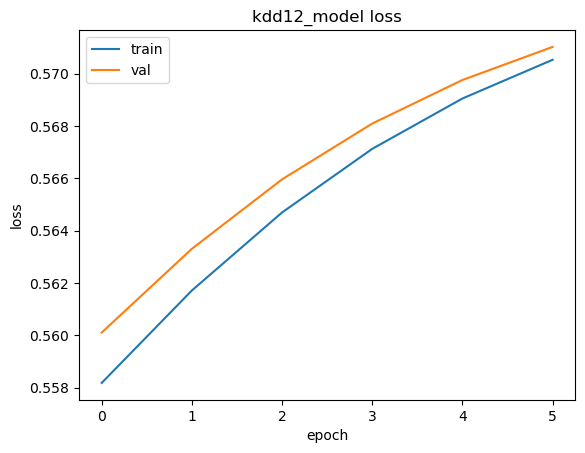

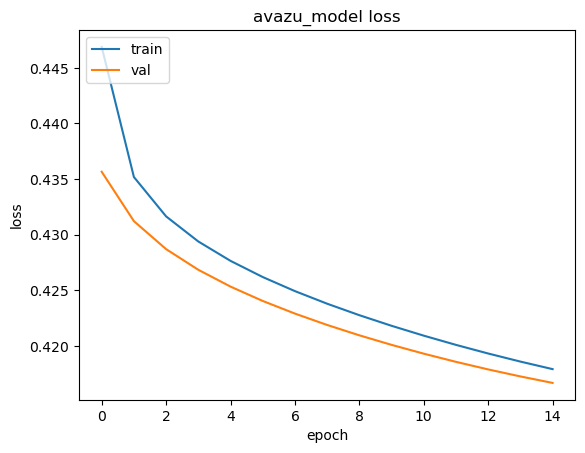

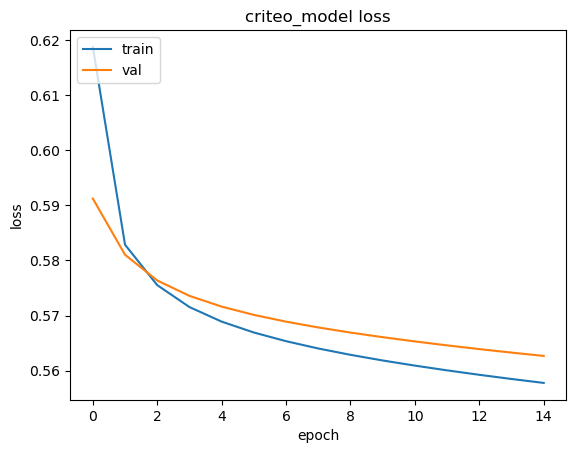

In [59]:
# Plot the training and validation losses for each epoch
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_fm.csv')
avazu_history = pd.read_csv('logs/avazu_fm.csv')
criteo_history = pd.read_csv('logs/criteo_fm.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Deep Models

As explained above, I will explore a number of deep learning models. I selected five popular models on the basis of the following criteria

- Competitive predition accuracy in the KDD12, Criteo and Avazu datasets as published on [PapersWithCode](https://paperswithcode.com/)
- Ideally, I was looking for a representitive set of models for each model type as discussed in (Zhang et. al. 2021). Therefore I was looking for models that employed Product Interaction Opetators, Attention Operators and Factorization Machines as a basis.
- The code for the model has to be accessible and intuitive to use.

On the basis of the above critea, I have chosen the following models to explore:

- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Automatic Feature Interaction (AutoInt)

In the section below, I briefly introduce each of the models, and evaluate against the benchmark datasets loaded and preprocessed above.

### Factorization-Machine Supported Neural Networks

The first Deep Learning model that we will consider is the Factorization Supported
Neural Network (FNN) model proposed by Zhang et. al. (2016). The model works by first training a Factorization Machine
model on the sparse-encoded categorical input features. It then uses the latent vectors learned by the FM model (see $\mathbf{v}_i$ in the equation above)
as inputs to a Neural Network, as shown in the figure below. In doing so, the FNN model is effectively using the FM latent factors to initialize the embedding layer of the Neural Network.
The DNN is then able to learn the higher order feature interactions in the data, which the FM model is unable to capture.

![FNN](figures/fnn.png)

In [60]:
# Compile the models
kdd12_fnn_model = FNN(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
kdd12_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''
avazu_fnn_model = FNN(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
avazu_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_fnn_model = FNN(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005
    )
criteo_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''

'\navazu_fnn_model = FNN(\n    avazu_linear_feature_columns, \n    avazu_dnn_feature_columns, \n    task=\'binary\',\n    dnn_hidden_units=[200,200,200],\n    dnn_dropout=0.6,\n    l2_reg_dnn=0.005,\n    l2_reg_linear = 0.005,\n    l2_reg_embedding=0.005\n    )\navazu_fnn_model.compile("adam", "binary_crossentropy", metrics=[\'binary_crossentropy\',\'binary_accuracy\',precision,recall,auc], )\n\ncriteo_fnn_model = FNN(\n    criteo_linear_feature_columns, \n    criteo_dnn_feature_columns, \n    task=\'binary\',\n    dnn_hidden_units=[200,200,200],\n    dnn_dropout=0.6,\n    l2_reg_dnn=0.005,\n    l2_reg_linear = 0.005,\n    l2_reg_embedding=0.005\n    )\ncriteo_fnn_model.compile("adam", "binary_crossentropy", metrics=[\'binary_crossentropy\',\'binary_accuracy\',precision,recall,auc], )\n'

In [61]:
# Define the CSVLogger callbacks
kdd12_fnn_csvLogger = CSVLogger('logs/kdd12_fnn.csv')
avazu_fnn_csvLogger = CSVLogger('logs/avazu_fnn.csv')
criteo_fnn_csvLogger = CSVLogger('logs/criteo_fnn.csv')

In [62]:
# Define the model saving checkpoints
kdd12_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/kdd12/kdd12_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/avazu/avazu_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_fnn_modelCheckpoint = ModelCheckpoint(
    'models/fnn/criteo/criteo_fnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [63]:
# Fit the models
kdd12_fnn_history = kdd12_fnn_model.fit(kdd12_train_model_input, validation_data=kdd12_val_model_input, batch_size=256, epochs=15, callbacks=[kdd12_fnn_csvLogger,kdd12_fnn_modelCheckpoint,earlystopping], class_weight=kdd12_class_weights)
#avazu_fnn_history = avazu_fnn_model.fit(avazu_train_model_input, validation_data=avazu_val_model_input, batch_size=256, epochs=15, callbacks=[avazu_fnn_csvLogger,avazu_fnn_modelCheckpoint,earlystopping])
#criteo_fnn_history = criteo_fnn_model.fit(criteo_train_model_input, validation_data=criteo_val_model_input, batch_size=256, epochs=15, callbacks=[criteo_fnn_csvLogger,criteo_fnn_modelCheckpoint,earlystopping])

Epoch 1/15


2024-08-27 18:34:17.838592: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa4a841e160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-27 18:34:17.838623: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-27 18:34:17.873682: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 18:34:17.959181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-08-27 18:34:18.083147: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    614/Unknown - 24s 30ms/step - loss: 0.9125 - binary_crossentropy: 0.5921 - binary_accuracy: 0.7206 - precision: 0.0614 - recall: 0.3582 - auc: 0.6112

2024-08-27 18:34:38.563794: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10475788890055765598
2024-08-27 18:34:43.616952: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3157454066980074299
2024-08-27 18:34:43.616992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8512027479184977550


615/615 [==============================] - 31s 40ms/step - loss: 0.9119 - binary_crossentropy: 0.5921 - binary_accuracy: 0.7206 - precision: 0.0614 - recall: 0.3583 - auc: 0.6111 - val_loss: 0.6288 - val_binary_crossentropy: 0.5748 - val_binary_accuracy: 0.7518 - val_precision: 0.0776 - val_recall: 0.4652 - val_auc: 0.6701
Epoch 2/15
615/615 [==============================] - 23s 37ms/step - loss: 0.6433 - binary_crossentropy: 0.5777 - binary_accuracy: 0.7397 - precision: 0.0683 - recall: 0.4282 - auc: 0.6403 - val_loss: 0.6263 - val_binary_crossentropy: 0.5860 - val_binary_accuracy: 0.6975 - val_precision: 0.0702 - val_recall: 0.5224 - val_auc: 0.6700
Epoch 3/15
615/615 [==============================] - 23s 37ms/step - loss: 0.6295 - binary_crossentropy: 0.5712 - binary_accuracy: 0.7286 - precision: 0.0699 - recall: 0.4624 - auc: 0.6500 - val_loss: 0.5943 - val_binary_crossentropy: 0.5606 - val_binary_accuracy: 0.7314 - val_precision: 0.0762 - val_recall: 0.5006 - val_auc: 0.6759
Epo

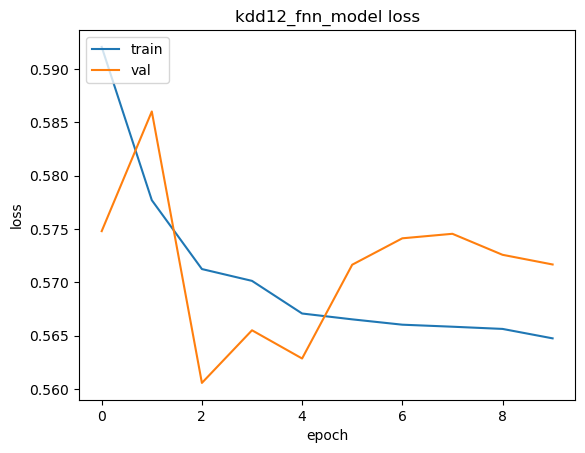

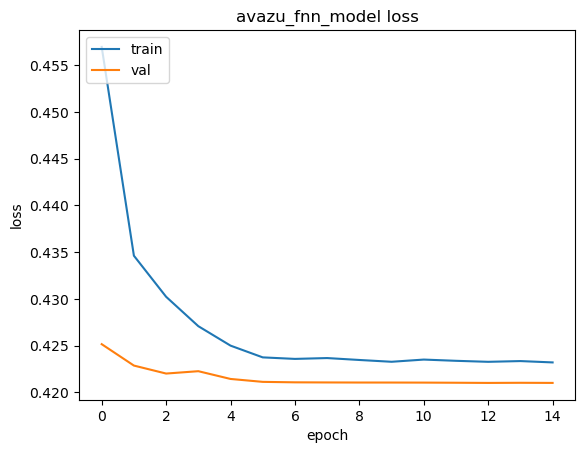

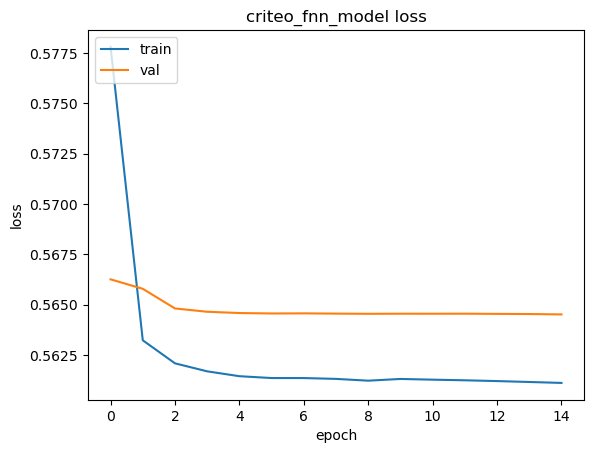

In [64]:
# Read in the history logs
kdd12_fnn_history = pd.read_csv('logs/kdd12_fnn.csv')
avazu_fnn_history = pd.read_csv('logs/avazu_fnn.csv')
criteo_fnn_history = pd.read_csv('logs/criteo_fnn.csv')

# Plot the training history
plt.plot(kdd12_fnn_history['binary_crossentropy'])
plt.plot(kdd12_fnn_history['val_binary_crossentropy'])
plt.title('kdd12_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_fnn_history['binary_crossentropy'])
plt.plot(avazu_fnn_history['val_binary_crossentropy'])
plt.title('avazu_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_fnn_history['binary_crossentropy'])
plt.plot(criteo_fnn_history['val_binary_crossentropy'])
plt.title('criteo_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Product Based Neural Networks

The Product Based Neural Network (PNN) model
proposed by Qu et. al. (2016) is another Deep Learning
model that was developed around the same time as the FNN model. The key 
innovation of the PNN moel is the use of a pair-wisely connected Product Layer
after a field-wise connected embetting layer for the categorical features, as shown
in the figure below. The Product Layer is able to directly model inter-field feature
interaction by means of either an inner product or outer production operation, and then further
distill higher feature inturactions by passing the output of the Product Layer through fully
connected MLP layers.

![PNN](figures/pnn.png)

In [ ]:
# Define the CSVLogger callbacks
kdd12_pnn_csvLogger = CSVLogger('logs/kdd12_pnn.csv')
avazu_pnn_csvLogger = CSVLogger('logs/avazu_pnn.csv')
criteo_pnn_csvLogger = CSVLogger('logs/criteo_pnn.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/kdd12/kdd12_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/avazu/avazu_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_pnn_modelCheckpoint = ModelCheckpoint(
    'models/pnn/criteo/criteo_pnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Compile the PNN models
kdd12_pnn_model = PNN(
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
kdd12_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''
avazu_pnn_model = PNN(
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
avazu_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_pnn_model = PNN(
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
criteo_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''

In [ ]:
# Fit the models

kdd12_pnn_history = kdd12_pnn_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_pnn_csvLogger,kdd12_pnn_modelCheckpoint,earlystopping]
)
'''
avazu_pnn_history = avazu_pnn_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_pnn_csvLogger,avazu_pnn_modelCheckpoint,earlystopping]
)
criteo_pnn_history = criteo_pnn_model.fit(
    criteo_train_model_input,
    validation_data=criteo_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_pnn_csvLogger,criteo_pnn_modelCheckpoint,earlystopping]
)
'''

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_pnn.csv')
avazu_history = pd.read_csv('logs/avazu_pnn.csv')
criteo_history = pd.read_csv('logs/criteo_pnn.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Neural Factorization Machines

In [47]:
# Define the CSVLogger callbacks
kdd12_nfm_csvLogger = CSVLogger('logs/kdd12_nfm.csv')
avazu_nfm_csvLogger = CSVLogger('logs/avazu_nfm.csv')
criteo_nfm_csvLogger = CSVLogger('logs/criteo_nfm.csv')

In [48]:
# Define the model saving checkpoints
kdd12_nfm_modelCheckpoint = ModelCheckpoint(
    'models/nfm/kdd12/kdd12_nfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_nfm_modelCheckpoint = ModelCheckpoint(
    'models/nfm/avazu/avazu_nfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_nfm_modelCheckpoint = ModelCheckpoint(
    'models/nfm/criteo/criteo_nfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [49]:
# Compile the PNN models
kdd12_nfm_model = NFM(
    kdd12_linear_feature_columns,
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
kdd12_nfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''
avazu_nfm_model = NFM(
    avazu_linear_feature_columns,
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
avazu_nfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_nfm_model = NFM(
    criteo_linear_feature_columns,
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    )
criteo_nfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''

'\navazu_nfm_model = NFM(\n    avazu_linear_feature_columns,\n    avazu_dnn_feature_columns, \n    task=\'binary\',\n    dnn_hidden_units=[200,200,200],\n    dnn_dropout=0.6,\n    l2_reg_dnn=0.005,\n    l2_reg_embedding=0.005,\n    )\navazu_nfm_model.compile("adam", "binary_crossentropy", metrics=[\'binary_crossentropy\',\'binary_accuracy\',precision,recall,auc], )\n\ncriteo_nfm_model = NFM(\n    criteo_linear_feature_columns,\n    criteo_dnn_feature_columns, \n    task=\'binary\',\n    dnn_hidden_units=[200,200,200],\n    dnn_dropout=0.6,\n    l2_reg_dnn=0.005,\n    l2_reg_embedding=0.005,\n    )\ncriteo_nfm_model.compile("adam", "binary_crossentropy", metrics=[\'binary_crossentropy\',\'binary_accuracy\',precision,recall,auc], )\n'

In [50]:
# Fit the models

kdd12_nfm_history = kdd12_nfm_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_nfm_csvLogger,kdd12_nfm_modelCheckpoint,earlystopping]
)
'''
avazu_nfm_history = avazu_nfm_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_nfm_csvLogger,avazu_nfm_modelCheckpoint,earlystopping]
)
criteo_nfm_history = criteo_nfm_model.fit(
    criteo_train_model_input,
    validation_data=criteo_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_nfm_csvLogger,criteo_nfm_modelCheckpoint,earlystopping]
)
'''

Epoch 1/15


2024-08-27 13:18:37.556729: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5616de414590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-27 13:18:37.556774: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-08-27 13:18:37.561990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 13:18:37.580117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-08-27 13:18:37.669465: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    614/Unknown - 25s 32ms/step - loss: 0.3707 - binary_crossentropy: 0.1805 - binary_accuracy: 0.9563 - precision: 0.0520 - recall: 0.0030 - auc: 0.5448

2024-08-27 13:18:59.488570: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4594587061644418997
2024-08-27 13:18:59.488632: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13537478827882812016
2024-08-27 13:18:59.488643: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9812719892594781972


615/615 [==============================] - 31s 42ms/step - loss: 0.3703 - binary_crossentropy: 0.1804 - binary_accuracy: 0.9564 - precision: 0.0520 - recall: 0.0030 - auc: 0.5448 - val_loss: 0.1741 - val_binary_crossentropy: 0.1665 - val_binary_accuracy: 0.9591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6202
Epoch 2/15
615/615 [==============================] - 25s 40ms/step - loss: 0.1670 - binary_crossentropy: 0.1625 - binary_accuracy: 0.9594 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6676 - val_loss: 0.1665 - val_binary_crossentropy: 0.1633 - val_binary_accuracy: 0.9591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6638
Epoch 3/15
487/615 [======================>.......] - ETA: 3s - loss: 0.1577 - binary_crossentropy: 0.1542 - binary_accuracy: 0.9596 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7502

KeyboardInterrupt: 

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_nfm.csv')
avazu_history = pd.read_csv('logs/avazu_nfm.csv')
criteo_history = pd.read_csv('logs/criteo_nfm.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_nfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_nfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_nfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Deep And Cross Network

In [ ]:
# Define the CSVLogger callbacks
kdd12_dcn_csvLogger = CSVLogger('logs/kdd12_dcn.csv')
avazu_dcn_csvLogger = CSVLogger('logs/avazu_dcn.csv')
criteo_dcn_csvLogger = CSVLogger('logs/criteo_dcn.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_dcn_modelCheckpoint = ModelCheckpoint(
    'models/dcn/kdd12/kdd12_dcn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_dcn_modelCheckpoint = ModelCheckpoint(
    'models/dcn/avazu/avazu_dcn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_dcn_modelCheckpoint = ModelCheckpoint(
    'models/dcn/criteo/criteo_dcn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Compile the PNN models
kdd12_dcn_model = DCN(
    kdd12_linear_feature_columns,
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True,
    )
kdd12_dcn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''
avazu_dcn_model = DCN(
    avazu_linear_feature_columns,
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True,
    )
avazu_dcn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_dcn_model = DCN(
    criteo_linear_feature_columns,
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True,
    )
criteo_dcn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''

In [ ]:
# Fit the models

kdd12_dcn_history = kdd12_dcn_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_dcn_csvLogger,kdd12_dcn_modelCheckpoint,earlystopping]
)
'''
avazu_dcn_history = avazu_dcn_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_dcn_csvLogger,avazu_dcn_modelCheckpoint,earlystopping]
)
criteo_dcn_history = criteo_dcn_model.fit(
    criteo_train_model_input,
    validation_data=criteo_val_model_input,
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_dcn_csvLogger,criteo_dcn_modelCheckpoint,earlystopping]
)
'''

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_dcn.csv')
avazu_history = pd.read_csv('logs/avazu_dcn.csv')
criteo_history = pd.read_csv('logs/criteo_dcn.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_dcn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_dcn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_dcn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Wide and Deep

The Wide \& Deep Learning (WDL) model proposed by Cheng et. al. (2016) introduces the concept
of dual-tower model architecture (Zhang et. al. 2021). While both the FNN and the PNN models
generally tend to be constructed as a single fully connected DNN model, the Wide \& Deep model
consists of a wide component, consisting of a three layer Deep Neural Network that takes the concatinated
embedding vectors of the categorical features as input, and a deep component, consisting of a cross product
transformation of selected sparse categorical features. The logits from the wide and deep components are added
together to produce the final prediction. The architecture of the WDL model is shown in the figure below.

![WDL](figures/wdl.png)

The purpose behind the Dual-Tower architecture is to counteract the tendancy of the fully connected
single tower DNN models to lose the ability to capture low-order feature interactions (Zhang et. al. 2021).
The Wide component is able to capture the low-order feature interactions, while the Deep component is able to capture
the higher order feature interactions.

In [ ]:
# Compile the WDL models
kdd12_wdl_model = WDL(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
kdd12_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''
avazu_wdl_model = WDL(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
avazu_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_wdl_model = WDL(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
criteo_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''

In [ ]:
# Define the CSVLogger callbacks
kdd12_wdl_csvLogger = CSVLogger('logs/kdd12_wdl.csv')
avazu_wdl_csvLogger = CSVLogger('logs/avazu_wdl.csv')
criteo_wdl_csvLogger = CSVLogger('logs/criteo_wdl.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/kdd12/kdd12_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/avazu/avazu_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_wdl_modelCheckpoint = ModelCheckpoint(
    'models/wdl/criteo/criteo_wdl.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the Wide and Deep models

kdd12_wdl_history = kdd12_wdl_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[kdd12_wdl_csvLogger,kdd12_wdl_modelCheckpoint,earlystopping]
)
'''
avazu_wdl_history = avazu_wdl_model.fit(
    avazu_train_model_input, 
    validation_data=avazu_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_wdl_csvLogger,avazu_wdl_modelCheckpoint,earlystopping]


criteo_wdl_history = criteo_wdl_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_wdl_csvLogger, criteo_wdl_modelCheckpoint,earlystopping]
)
'''

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_wdl.csv')
avazu_history = pd.read_csv('logs/avazu_wdl.csv')
criteo_history = pd.read_csv('logs/criteo_wdl.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### DeepFM

The DeepFM model proposed by Guo et. al. 2017 can be thought of as an
imporvement of the aforementioned FNN (Zhang et. al., 2016) and WDL (Cheng et. al., 2016) models.
Like the FNN model, the DeepFM model usilises the Factorization Machine model (Rendel, 2010)
to learn lower-order feature interactions. However, it also employs a dual-tower architecture
like the WDL model, with the Wide component being the FM model and the Deep component being a fully connected
DNN model. The DeepFM model is therefore able to avoid the limitations on capturing low-order
interactions that are inherent in the FNN model. In addition, due the the application of the FM to all
feature embeddings, the DeepFM model eliminates the need to choose which features 
to feed through the wide component, as is the case in the WDL model. The architecture of the DeepFM model is shown 
in the figure below.

![DFM](figures/dfm.png)

In [ ]:
# Compile the DeepFM models

kdd12_dfm_model = DeepFM(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
kdd12_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''
avazu_dfm_model = DeepFM(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
avazu_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_dfm_model = DeepFM(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
)
criteo_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''

In [ ]:
# Define the CSVLogger callbacks
kdd12_dfm_csvLogger = CSVLogger('logs/kdd12_dfm.csv')
avazu_dfm_csvLogger = CSVLogger('logs/avazu_dfm.csv')
criteo_dfm_csvLogger = CSVLogger('logs/criteo_dfm.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/kdd12/kdd12_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/avazu/avazu_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_dfm_modelCheckpoint = ModelCheckpoint(
    'models/dfm/criteo/criteo_dfm.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the DeepFM models

kdd12_dfm_history = kdd12_dfm_model.fit(
    kdd12_train_model_input, 
    validation_data = kdd12_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[kdd12_dfm_csvLogger,kdd12_dfm_modelCheckpoint,earlystopping]
)
'''
avazu_dfm_history = avazu_dfm_model.fit(
    avazu_train_model_input, 
    validation_data= avazu_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_dfm_csvLogger,avazu_dfm_modelCheckpoint,earlystopping]
)

criteo_dfm_history = criteo_dfm_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, epochs=15,
    callbacks=[criteo_dfm_csvLogger,criteo_dfm_modelCheckpoint,earlystopping]
)
'''

In [ ]:
# Read in the history logs
kdd12_dfm_history = pd.read_csv('logs/kdd12_dfm.csv')
avazu_dfm_history = pd.read_csv('logs/avazu_dfm.csv')
criteo_dfm_history = pd.read_csv('logs/criteo_dfm.csv')

# Plot the training history
plt.plot(kdd12_dfm_history['binary_crossentropy'])
plt.plot(kdd12_dfm_history['val_binary_crossentropy'])
plt.title('kdd12_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_dfm_history['binary_crossentropy'])
plt.plot(avazu_dfm_history['val_binary_crossentropy'])
plt.title('avazu_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_dfm_history['binary_crossentropy'])
plt.plot(criteo_dfm_history['val_binary_crossentropy'])
plt.title('criteo_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Automatic Feature Interaction (AutoInt)

The Autotomatic Feature Interaction Learning (AutoInt) model proposed by
Song et. al. (2019) makes use of a multi-head self attention
network to model the important feature interactions in the data. The initial 
paper separates the model into three parts: an embedding layer, an interaction layer 
and an output layer. The embedding layer aims to project each sparse multi-value
categorical a and dense numerical feature into a lower dimensional space, as per the below:

$$
\mathbf{e_i} = \frac{1}{q} \mathbf{V_i x_i}
$$

where $\mathbf{V_i}$ is the embedding matrix for the $i$-th field, $x_i$ is a multi-hot vector, and $q$ 
is the number of non-zero values in $x_i$. The interaction layer employs the multi-head
mechanism to determine which higher order feature interaction are meaningful in the data. This not only
improves the efficiency of model traning, but it also improves the model's explainability. Lastly,
the output layer is a fully connected layer that takes in the concatinated output 
of the interaction layer, and applies the sigmoid activation function to produce the final prediction.
The architecture of the AutoInt model is shown in Figure below.

![AUTOINT](figures/autoint.png)

In [ ]:
# Compile the AutoInt Models
kdd12_autoint_model = AutoInt(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
kdd12_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''
avazu_autoint_model = AutoInt(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
avazu_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

criteo_autoint_model = AutoInt(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
criteo_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )
'''

In [ ]:
# Define the AutoInt CSVLogger callbacks
kdd12_autoint_csvLogger = CSVLogger('logs/kdd12_autoint.csv')
avazu_autoint_csvLogger = CSVLogger('logs/avazu_autoint.csv')
criteo_autoint_csvLogger = CSVLogger('logs/criteo_autoint.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/kdd12/kdd12_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/avazu/avazu_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_autoint_modelCheckpoint = ModelCheckpoint(
    'models/autoint/criteo/criteo_autoint.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the AutoInt models

kdd12_autoint_model.fit(
    kdd12_train_model_input, 
    validation_data= kdd12_val_model_input, 
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_autoint_csvLogger, kdd12_autoint_modelCheckpoint,earlystopping]
)
'''
avazu_autoint_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[avazu_autoint_csvLogger, avazu_autoint_modelCheckpoint,earlystopping]
)
criteo_autoint_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_autoint_csvLogger,criteo_autoint_modelCheckpoint,earlystopping]
)
'''

In [ ]:
# Read in the history logs
kdd12_autoint_history = pd.read_csv('logs/kdd12_autoint.csv')
avazu_autoint_history = pd.read_csv('logs/avazu_autoint.csv')
criteo_autoint_history = pd.read_csv('logs/criteo_autoint.csv')

# Plot the training history
plt.plot(kdd12_autoint_history['binary_crossentropy'])
plt.plot(kdd12_autoint_history['val_binary_crossentropy'])
plt.title('kdd12_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_autoint_history['binary_crossentropy'])
plt.plot(avazu_autoint_history['val_binary_crossentropy'])
plt.title('avazu_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_autoint_history['binary_crossentropy'])
plt.plot(criteo_autoint_history['val_binary_crossentropy'])
plt.title('criteo_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Convolutional Click Prediction Model

In [ ]:
## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns_ccpm = [SparseFeat(feat.lower(), vocabulary_size=kdd12_vocab_lengths[feat], embedding_dim=4) for feat in kdd12_categorical_columns]
kdd12_linear_feature_columns_ccpm = [DenseFeat(feat.lower(),1) for feat in kdd12_numerical_columns]
'''
avazu_dnn_feature_columns_ccpm = [SparseFeat(feat, vocabulary_size=avazu_vocab_lengths[feat], embedding_dim=4) for feat in avazu_categorical_columns]
avazu_linear_feature_columns_ccpm = [DenseFeat(feat,1) for feat in avazu_numerical_columns]

criteo_dnn_feature_columns_ccpm = [SparseFeat(feat, vocabulary_size=criteo_vocab_lengths[feat], embedding_dim=4) for feat in criteo_categorical_columns]
criteo_linear_feature_columns_ccpm = [DenseFeat(feat,1) for feat in criteo_numerical_columns]
'''

In [ ]:
# Compile the Models

kdd12_ccpm_model = CCPM(
    kdd12_linear_feature_columns_ccpm, 
    kdd12_dnn_feature_columns_ccpm, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
kdd12_ccpm_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
)
'''
avazu_ccpm_model = CCPM(
    avazu_linear_feature_columns_ccpm, 
    avazu_dnn_feature_columns_ccpm, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
avazu_ccpm_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
)

criteo_ccpm_model = CCPM(
    criteo_linear_feature_columns_ccpm, 
    criteo_dnn_feature_columns_ccpm, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    )
criteo_ccpm_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
)
'''

In [ ]:
# Define the AutoInt CSVLogger callbacks
kdd12_ccpm_csvLogger = CSVLogger('logs/kdd12_ccpm.csv')
avazu_ccpm_csvLogger = CSVLogger('logs/avazu_ccpm.csv')
criteo_ccpm_csvLogger = CSVLogger('logs/criteo_ccpm.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_ccpm_modelCheckpoint = ModelCheckpoint(
    'models/ccpm/kdd12/kdd12_ccpm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_ccpm_modelCheckpoint = ModelCheckpoint(
    'models/ccpm/avazu/avazu_ccpm.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_ccpm_modelCheckpoint = ModelCheckpoint(
    'models/ccpm/criteo/criteo_ccpm.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the  models

kdd12_ccpm_model.fit(
    kdd12_train_model_input, 
    validation_data= kdd12_val_model_input, 
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_ccpm_csvLogger, kdd12_ccpm_modelCheckpoint,earlystopping]
)
'''
avazu_ccpm_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[avazu_ccpm_csvLogger, avazu_ccpm_modelCheckpoint,earlystopping]
)
criteo_ccpm_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_ccpm_csvLogger,criteo_ccpm_modelCheckpoint,earlystopping]
)
'''

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_ccpm.csv')
avazu_history = pd.read_csv('logs/avazu_ccpm.csv')
criteo_history = pd.read_csv('logs/criteo_ccpm.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_ccpm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_ccpm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_ccpm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Feature Generation by Convolutional Neural Network

In [ ]:
# Compile the AutoInt Models

kdd12_fgcnn_model = FGCNN(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    pooling_width=[2,2,2,1]
    )
kdd12_fgcnn_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
    run_eagerly=True,
)
'''
avazu_fgcnn_model = FGCNN(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    pooling_width=[2,2,2,1]
    )
avazu_fgcnn_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
    run_eagerly=True,
)

criteo_fgcnn_model = FGCNN(
    criteo_linear_feature_columns, 
    criteo_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=[200,200,200],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    pooling_width=[2,2,2,1]
    )
criteo_fgcnn_model.compile(
    "adam", 
    "binary_crossentropy", 
    metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc],
    run_eagerly=True,
)
'''

In [ ]:
# Define the AutoInt CSVLogger callbacks
kdd12_fgcnn_csvLogger = CSVLogger('logs/kdd12_fgcnn.csv')
avazu_fgcnn_csvLogger = CSVLogger('logs/avazu_fgcnn.csv')
criteo_fgcnn_csvLogger = CSVLogger('logs/criteo_fgcnn.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_fgcnn_modelCheckpoint = ModelCheckpoint(
    'models/fgcnn/kdd12/kdd12_fgcnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
avazu_fgcnn_modelCheckpoint = ModelCheckpoint(
    'models/fgcnn/avazu/avazu_fgcnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)
criteo_fgcnn_modelCheckpoint = ModelCheckpoint(
    'models/fgcnn/criteo/criteo_fgcnn.ckpt',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Fit the FGCNN models

kdd12_fgcnn_model.fit(
    kdd12_train_model_input, 
    validation_data= kdd12_val_model_input, 
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_fgcnn_csvLogger, kdd12_fgcnn_modelCheckpoint,earlystopping]
)
'''
avazu_fgcnn_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[avazu_fgcnn_csvLogger, avazu_fgcnn_modelCheckpoint,earlystopping]
)
criteo_fgcnn_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_fgcnn_csvLogger,criteo_fgcnn_modelCheckpoint,earlystopping]
)
'''

In [ ]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_fgcnn.csv')
avazu_history = pd.read_csv('logs/avazu_fgcnn.csv')
criteo_history = pd.read_csv('logs/criteo_fgcnn.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_fgcnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_fgcnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_fgcnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Analysis of Results and Discussion

Below I construct and display a pandas dataframe of the best results in each of the logs in terms of validation loss. The accompanying validation metrics are also shown

In [65]:
# Construct pandas dataframe of the model scores for the kdd12 dataset
models = ['lr','fm','fnn','pnn','wdl','dfm','autoint','fgcnn','nfm','dcn','ccpm']
datasets = ['kdd12','avazu','criteo']

for dataset in datasets:
    df = pd.DataFrame()
    for model in models:
        log_file = f'logs/{dataset}_{model}.csv'
        history = pd.read_csv(log_file)
        min_loss = history[history['val_loss']==history['val_loss'].min()]
        min_loss_val = min_loss.loc[:,['epoch','val_binary_crossentropy','val_binary_accuracy','val_precision','val_recall','val_auc']]
        min_loss_val['model'] = model
        df = pd.concat([df,min_loss_val],axis=0)
    df = df.set_index('model')
    df.to_csv(f'logs/{dataset}_model_scores.csv')

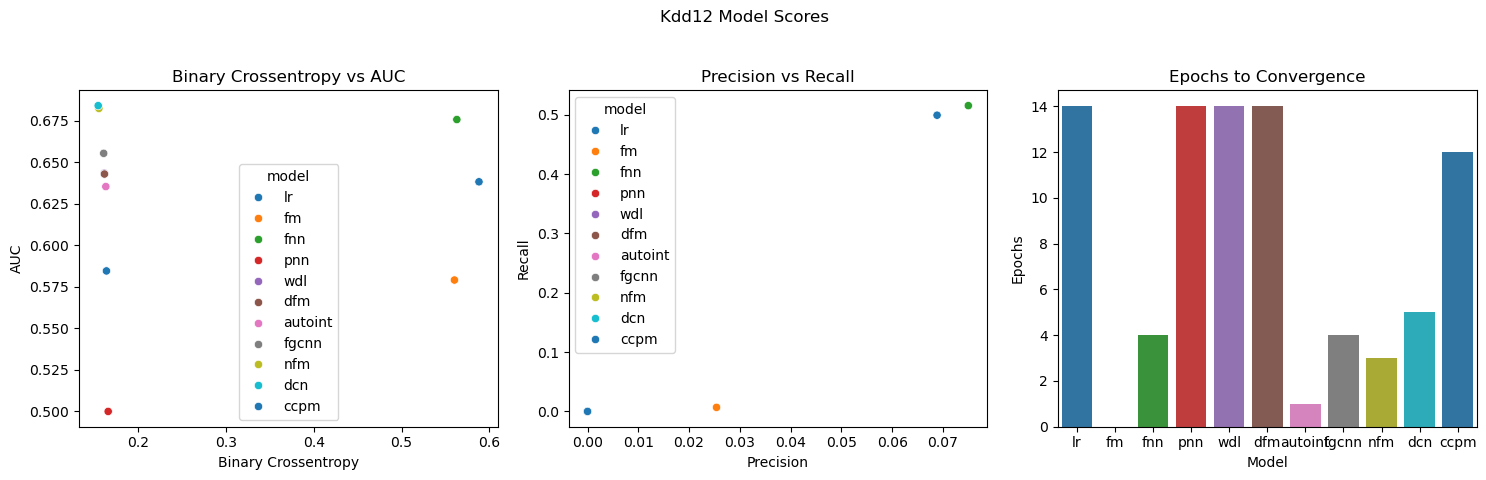

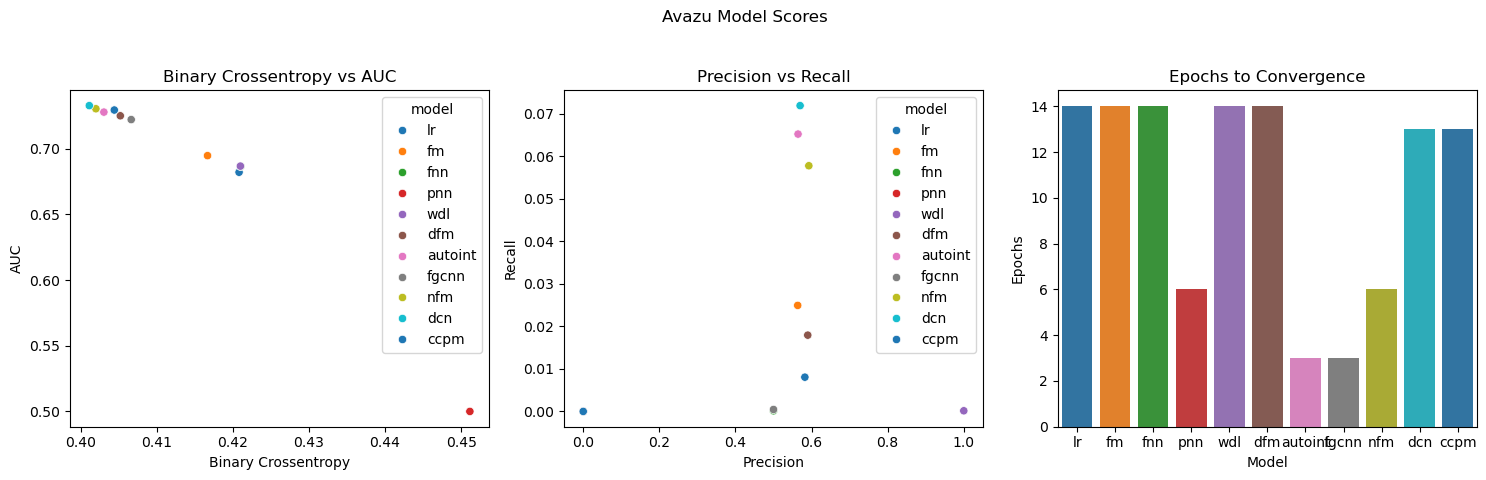

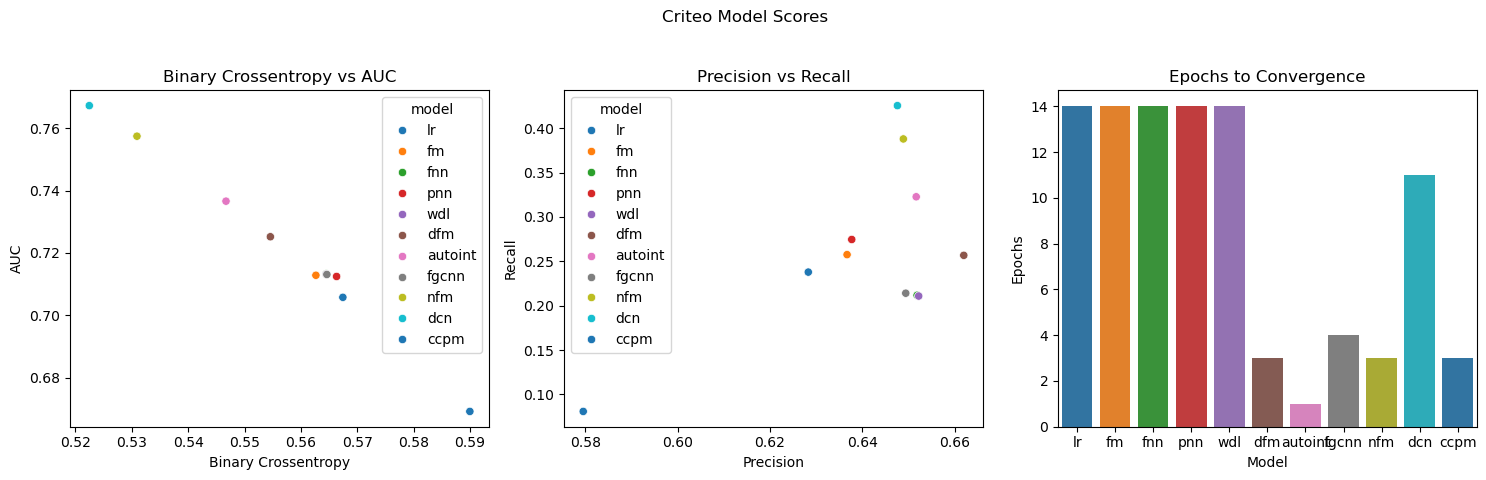

In [66]:
# Plot the the model scores by data set

for dataset in datasets:
    df = pd.read_csv(f'logs/{dataset}_model_scores.csv')
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{dataset.capitalize()} Model Scores')
    
    # Plot a scatter plot of binary crossentropy loss vs binary accuracy
    sns.scatterplot(ax=axs[0], data=df, x='val_binary_crossentropy', y='val_auc', hue='model', palette='tab10')
    axs[0].set_title('Binary Crossentropy vs AUC')
    axs[0].set_xlabel('Binary Crossentropy')
    axs[0].set_ylabel('AUC')

    # Plot a scatter plot of Precision vs Recall
    sns.scatterplot(ax=axs[1], data=df, x='val_precision', y='val_recall', hue='model', palette='tab10')
    axs[1].set_title('Precision vs Recall')
    axs[1].set_xlabel('Precision')
    axs[1].set_ylabel('Recall')

    # Plot a bar chart of epoch number by model
    sns.barplot(ax=axs[2], data=df, x='model', y='epoch', palette='tab10')
    axs[2].set_title('Epochs to Convergence')
    axs[2].set_xlabel('Model')
    axs[2].set_ylabel('Epochs')

    # Arrange the subplots so that the axis labels do not overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the figure in the figures folder and show the plot
    plt.savefig(f'figures/{dataset}_model_scores.png')
    plt.show()

## Hyperparameter Experimentation

In this section, I experiment with different hyperparameter settings for the DeepFM model, using the Avazu Dataset. Below I will experiment with:
- Neuron per layer count: 100, 200, 300, 400, 500
- Layer count: 2, 3, 4, 5, 6
- Architecture shape:
    - Flat: 200, 200, 200
    - Increasing: 100, 200, 300
    - Decreasing: 300, 200, 100
    - Diamond: 150, 300, 150

In [ ]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters'):
    os.mkdir('models/hyperparameters')

### Neuron per Layer

In [ ]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters/neuron_count'):
    os.mkdir('models/hyperparameters/neuron_count')

In [ ]:
def neuron_experiment(dnn_hidden_layers):
    precision = tf.keras.metrics.Precision(thresholds=0.5,name='precision')
    recall = tf.keras.metrics.Recall(thresholds=0.5,name='recall')
    auc = tf.keras.metrics.AUC(name='auc')
    
    model = DCN(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=dnn_hidden_layers,
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True
    )
    model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

    return model

In [ ]:
for neurons in [100,200,300,400,500]:
    if not os.path.exists(f'models/hyperparameters/neuron_count/{str(neurons)}'):
        os.mkdir(f'models/hyperparameters/neuron_count/{str(neurons)}')

    dnn_layers = 3*[neurons]
    model = neuron_experiment(dnn_layers)

    csvLogger = CSVLogger(f'logs/neuron_count_{str(neurons)}.csv')
    modelCheckpoint = ModelCheckpoint(
    f'models/hyperparameters/neuron_count/{str(neurons)}/neuron_count_{str(neurons)}.ckpt',
    save_best_only=True,
    save_weights_only=True
    )

    print(f"{str(neurons)} neurons:")
    model.fit(
        kdd12_train_model_input,
        validation_data = kdd12_val_model_input,
        batch_size=256,
        epochs=15,
        callbacks=[csvLogger,modelCheckpoint,earlystopping]
    )

In [ ]:
# Plot the minimum validation loss
summary_df = pd.DataFrame(index=np.arange(100,600,100),data={
    "binary_crossentropy":np.zeros(5,dtype=float),
    "auc":np.zeros(5,dtype=float)
})

for neurons in [100,200,300,400,500]:
    df = pd.read_csv(f'logs/neuron_count_{str(neurons)}.csv')
    binary_crossentropy = df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]
    auc = df[df.val_loss == df.val_loss.min()].auc.values[0]
    summary_df.loc[neurons,['binary_crossentropy']] = binary_crossentropy
    summary_df.loc[neurons,['auc']] = auc

# Plot the result
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.suptitle("Neurons per layer")
ax[0].set_title('Binary Crossentropy')
ax[0].set_xlabel('Neurons per layer')
ax[0].plot(summary_df.index,summary_df.binary_crossentropy)

ax[1].set_title('AUC')
ax[1].set_xlabel('Neurons per layer')
ax[1].plot(summary_df.index,summary_df.auc)

plt.show()

In [ ]:
df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]

### Number of layers

In [ ]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters/layers'):
    os.mkdir('models/hyperparameters/layers')

In [ ]:
for layers in [2,3,4,5,6]:
    if not os.path.exists(f'models/hyperparameters/layers/{str(layers)}'):
        os.mkdir(f'models/hyperparameters/layers/{str(layers)}')

    dnn_layers = layers*[200]
    model = neuron_experiment(dnn_layers)

    csvLogger = CSVLogger(f'logs/layers_{layers}.csv')
    modelCheckpoint = ModelCheckpoint(
    f'models/hyperparameters/layers/{str(layers)}/layers_{str(layers)}.ckpt',
    save_best_only=True,
    save_weights_only=True
    )

    print(f"{str(layers)} layers:")
    model.fit(
        kdd12_train_model_input,
        validation_data = kdd12_val_model_input,
        batch_size=256,
        epochs=15,
        callbacks=[csvLogger,modelCheckpoint,earlystopping]
    )

In [ ]:
# Plot the minimum validation loss
summary_df = pd.DataFrame(index=np.arange(2,7),data={
    "binary_crossentropy":np.zeros(5,dtype=float),
    "auc":np.zeros(5,dtype=float)
})

for neurons in [2,3,4,5,6]:
    df = pd.read_csv(f'logs/layers_{str(neurons)}.csv')
    binary_crossentropy = df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]
    auc = df[df.val_loss == df.val_loss.min()].auc.values[0]
    summary_df.loc[neurons,['binary_crossentropy']] = binary_crossentropy
    summary_df.loc[neurons,['auc']] = auc


# Plot the result
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.suptitle("Layers")
ax[0].set_title('Binary Crossentropy')
ax[0].set_xlabel('Number of Layers')
ax[0].plot(summary_df.index,summary_df.binary_crossentropy)

ax[1].set_title('AUC')
ax[1].set_xlabel('Number of Layers')
ax[1].plot(summary_df.index,summary_df.auc)

plt.show()

### DNN Shape

In [ ]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters/shape'):
    os.mkdir('models/hyperparameters/shape')

In [ ]:
shapes = {
    'constant':[200,200,200],
    'increasing':[100,200,300],
    'decreasing':[300,200,100],
    'diamond':[150,300,150]
}

In [ ]:
for shape in list(shapes.keys()):
    if not os.path.exists(f'models/hyperparameters/shape/{shape}'):
        os.mkdir(f'models/hyperparameters/shape/{shape}')

    dnn_layers = shapes[shape]
    model = neuron_experiment(dnn_layers)

    csvLogger = CSVLogger(f'logs/shape_{shape}.csv')
    modelCheckpoint = ModelCheckpoint(
    f'models/hyperparameters/shape/{shape}/shape_{shape}.ckpt',
    save_best_only=True,
    save_weights_only=True
    )

    print(f"{shape.capitalize()}:")
    model.fit(
        kdd12_train_model_input,
        validation_data = kdd12_val_model_input,
        batch_size=256,
        epochs=15,
        callbacks=[csvLogger,modelCheckpoint,earlystopping]
    )

In [ ]:
# Plot the minimum validation loss
summary_df = pd.DataFrame(index=np.arange(4),data={
    "binary_crossentropy":np.zeros(4,dtype=float),
    "auc":np.zeros(4,dtype=float)
})

shape_names = list(shapes.keys())

for neurons in range(4):
    df = pd.read_csv(f'logs/shape_{shape_names[neurons]}.csv')
    binary_crossentropy = df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]
    auc = df[df.val_loss == df.val_loss.min()].auc.values[0]
    summary_df.loc[neurons,['binary_crossentropy']] = binary_crossentropy
    summary_df.loc[neurons,['auc']] = auc


# Plot the result
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.suptitle("Shape")
ax[0].set_title('Binary Crossentropy')
ax[0].set_xlabel('Shape')
ax[0].plot(summary_df.index,summary_df.binary_crossentropy)
ax[0].set_xticks(summary_df.index,shape_names)

ax[1].set_title('AUC')
ax[1].set_xlabel('Shape')
ax[1].plot(summary_df.index,summary_df.auc)
ax[1].set_xticks(summary_df.index,shape_names)

plt.show()

### Number of Cross layers

In [ ]:
# Create the model directory if it does not exist
if not os.path.exists('models/hyperparameters/cross_layers'):
    os.mkdir('models/hyperparameters/cross_layers')

In [ ]:
def neuron_experiment(dnn_hidden_layers,cross_num=2):
    precision = tf.keras.metrics.Precision(thresholds=0.5,name='precision')
    recall = tf.keras.metrics.Recall(thresholds=0.5,name='recall')
    auc = tf.keras.metrics.AUC(name='auc')
    
    model = DCN(
    kdd12_linear_feature_columns, 
    kdd12_dnn_feature_columns, 
    task='binary',
    dnn_hidden_units=dnn_hidden_layers,
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True,
    cross_num=cross_num,
    )
    model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall,auc], )

    return model

In [ ]:
for layers in [2,3,4,5,6]:
    if not os.path.exists(f'models/hyperparameters/cross_layers/{str(layers)}'):
        os.mkdir(f'models/hyperparameters/cross_layers/{str(layers)}')

    dnn_layers = 3*[200]
    model = neuron_experiment(dnn_layers,cross_num=layers)

    csvLogger = CSVLogger(f'logs/cross_layers_{layers}.csv')
    modelCheckpoint = ModelCheckpoint(
    f'models/hyperparameters/cross_layers/{str(layers)}/cross_layers_{str(layers)}.ckpt',
    save_best_only=True,
    save_weights_only=True
    )

    print(f"{str(layers)} cross layers:")
    model.fit(
        kdd12_train_model_input,
        validation_data = kdd12_val_model_input,
        batch_size=256,
        epochs=15,
        callbacks=[csvLogger,modelCheckpoint,earlystopping]
    )

In [ ]:
# Plot the minimum validation loss
summary_df = pd.DataFrame(index=np.arange(2,7),data={
    "binary_crossentropy":np.zeros(5,dtype=float),
    "auc":np.zeros(5,dtype=float)
})

for neurons in [2,3,4,5,6]:
    df = pd.read_csv(f'logs/cross_layers_{str(neurons)}.csv')
    binary_crossentropy = df[df.val_loss == df.val_loss.min()].val_binary_crossentropy.values[0]
    auc = df[df.val_loss == df.val_loss.min()].auc.values[0]
    summary_df.loc[neurons,['binary_crossentropy']] = binary_crossentropy
    summary_df.loc[neurons,['auc']] = auc


# Plot the result
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.suptitle("Layers")
ax[0].set_title('Binary Crossentropy')
ax[0].set_xlabel('Number of Cross Layers')
ax[0].plot(summary_df.index,summary_df.binary_crossentropy)

ax[1].set_title('AUC')
ax[1].set_xlabel('Number of Cross Layers')
ax[1].plot(summary_df.index,summary_df.auc)

plt.show()